In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# Importing the data

df = pd.read_csv("./spam-ham v2.csv", encoding='latin1')
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar then Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# renaming column names

df.rename(columns = {"v1":"Output", "v2":"text"}, inplace=True)

In [4]:
# Checking Data types

df.dtypes

Output    object
text      object
dtype: object

In [5]:
# Checking for null values

df.isnull().sum()

Output    0
text      0
dtype: int64

In [6]:
# Mapping Output values --> 1 if Spam, 0 if Ham

df['Output'] = np.where(df['Output']=='spam', 1, 0)

In [7]:
# Value Counts of Output

df.Output.value_counts()

Output
0    4825
1     747
Name: count, dtype: int64

In [ ]:
# As the data is already cleaned, there is no further cleaning required.

# Create a function to clean the data

stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub(r'[^\d\w\s]', '', text)
    text = re.sub('https:?\\S+ | www\.\S+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = " ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text = " ".join(text)
    
    return(text)

# Applying the function on 'text' to remove the stopwords, spaces, symbols, numbers, etc 

df["text"] = df["text"].apply(clean)

In [8]:
# Split the data into X and y
X = df['text'].values
y = df['Output'].values

# Split the data into train and test data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Instantiate Tokenizer()
# You should not apply fit_on_texts to your test data.

tok = Tokenizer()
tok.fit_on_texts(x_train)

In [10]:
# texts_to_sequences can be used on any text to have it automatically encoded as integers based on the learned vocabulary.

encoded_train = tok.texts_to_sequences(x_train)
encoded_test = tok.texts_to_sequences(x_test)
print(encoded_train[0:2])

[[38, 30, 8, 5, 275, 1995, 80, 117, 26, 11, 1660, 323, 10, 53, 18, 302, 30, 349, 1996], [802, 15, 2564, 1446, 1133, 193, 2565, 172, 12, 100, 1997, 44, 196, 1661, 2566, 1998, 2567, 21, 9, 4, 204, 1033, 226]]


In [11]:
# pad documents to a max length of words
#You must pad each text such that they are all the same length. Because DL models, expect the input to be in same shape.

max_length = 8
padded_train = pad_sequences(encoded_train, maxlen= max_length, padding = 'post')
padded_test = pad_sequences(encoded_test, maxlen= max_length, padding = 'post')
print(padded_train)

[[ 323   10   53 ...   30  349 1996]
 [1998 2567   21 ...  204 1033  226]
 [  83 1447    4 ...    2 3805 3806]
 ...
 [1482   30 2069 ...  241   30 2070]
 [ 765 1682 1165 ...    0    0    0]
 [   8  155   20 ...    8  291  176]]


In [12]:
# Now, text data is in numeric form, you can feed it into a model and start training.

In [13]:
# Define the model (or) Create an instance of Sequential model and add layers and activation functions
# Embedding layers helps to map high dimension text data to low dimension features that can be easily trained.
# A Sigmoid layer is added as the final layer, because this is a binary classification problem.

vocab_size = len(tok.word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summarize the model

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 24)             192744    
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 500)               96500     
                                                                 
 dense_1 (Dense)             (None, 250)               125250    
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               25100     
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [14]:
# The model trains for a number of epochs before stopping since it is no longer improving.
# This is made possible by the early stopping callback

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience =10)

# fit the model
model.fit(x = padded_train, y = y_train, epochs=50, validation_data = (padded_test, y_test), verbose=1,
         callbacks = [early_stop])

Epoch 1/50
140/140 [==============================] - 3s 9ms/step - loss: 0.2437 - accuracy: 0.8997 - val_loss: 0.0995 - val_accuracy: 0.9812
Epoch 2/50
140/140 [==============================] - 1s 8ms/step - loss: 0.0264 - accuracy: 0.9926 - val_loss: 0.0733 - val_accuracy: 0.9821
Epoch 3/50
140/140 [==============================] - 1s 8ms/step - loss: 0.0026 - accuracy: 0.9996 - val_loss: 0.1127 - val_accuracy: 0.9821
Epoch 4/50
140/140 [==============================] - 1s 8ms/step - loss: 1.7642e-04 - accuracy: 1.0000 - val_loss: 0.1282 - val_accuracy: 0.9812
Epoch 5/50
140/140 [==============================] - 1s 8ms/step - loss: 8.7738e-05 - accuracy: 1.0000 - val_loss: 0.1370 - val_accuracy: 0.9812
Epoch 6/50
140/140 [==============================] - 1s 8ms/step - loss: 3.7347e-05 - accuracy: 1.0000 - val_loss: 0.1432 - val_accuracy: 0.9812
Epoch 7/50
140/140 [==============================] - 1s 8ms/step - loss: 3.6714e-05 - accuracy: 1.0000 - val_loss: 0.1476 - val_accurac

In [15]:
#Model Evaluation 

# Using a threshold of 0.5, means that any predicted probability greater than 0.5 makes the prediction 1, else 0.

# Predict the labels of the test set
y_pred = (model.predict(padded_test) > 0.5).astype("int32")

# Print the accuracy score of the optimized model
print('Accuracy score: ', accuracy_score(y_test, y_pred))

# Print the confusion matrix of the optimized model
conf_mat = confusion_matrix(y_test, y_pred)
print('Confusion matrix: \n', conf_mat)

# Print the classification report of the optimized model
class_report = classification_report(y_test, y_pred)
print('Classification report: \n', class_report)

35/35 [==============================] - 0s 2ms/step
Accuracy score:  0.9820627802690582
Confusion matrix: 
 [[963   2]
 [ 18 132]]
Classification report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.88      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



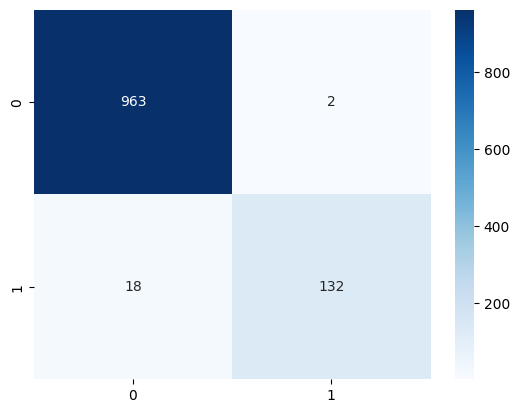

In [16]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap = 'Blues')
plt.show()

In [17]:
df.head(5)

,Output,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar then Joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
# Test the model with some custom email messages

input_msg = ["Go until jurong point, crazy.. Available only .."]
#tok = Tokenizer()
#tok.fit_on_texts(input_msg)
input_data_features = tok.texts_to_sequences(input_msg)
input_data_features = pad_sequences(input_data_features, maxlen=max_length, padding='post')
prediction = model.predict(input_data_features).astype("int32").item()
print(prediction)

if prediction == 1:
    print("Spam Message")
else:
    print("Ham Message")

1/1 [==============================] - 0s 20ms/step
0
Ham Message
